In [2]:
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import warnings, os
from glob import glob
from sklearn.utils import shuffle

import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

import aggmap
from aggmap import loadmap, aggmodel


import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
sns.set(style= 'white',font_scale = 1.2)

## fix random seed to get repeatale results
seed = 666
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
warnings.filterwarnings("ignore")

In [3]:
from config import P

seed = P.seed #for the random permutation
color_list = P.color_list

results_save_folder = P.results_save_folder
data_save_folder = P.mnist_data_save_folder
mnist_labels_dict = P.mnist_labels_dict

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)

testY = pd.get_dummies(y_test).values.astype(float)

In [5]:
mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))


In [6]:
model_OR1 = tf.keras.models.load_model('./results_data/model_Org1.h5')
model_ORS1 = tf.keras.models.load_model('./results_data/model_OrgRP1.h5')
model_ORSAgg1 = tf.keras.models.load_model('./results_data/model_OrgRPAgg1.h5')
model_ORSAggC5 = tf.keras.models.load_model('./results_data/model_OrgRPAgg5.h5')

In [7]:
testX_noisys = load(os.path.join(data_save_folder, 'testX_noisys.data'))
testX_noisys_shuffle = load(os.path.join(data_save_folder, 'testX_noisys_shuffle.data'))
testX_noisys_shuffle_ORSAgg1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data'))
testX_noisys_shuffle_ORSAggC5 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data'))

In [17]:
acc = []
loss = []
for xor, xors, xagg1,  xaggc5 in zip(testX_noisys, 
                                    testX_noisys_shuffle,
                                    testX_noisys_shuffle_ORSAgg1, 
                                    testX_noisys_shuffle_ORSAggC5):
    
    ls0, acc0 = model_OR1.evaluate(xor/255., testY, verbose = 0)
    ls1, acc1 = model_ORS1.evaluate(xors/255., testY, verbose = 0)
    ls2, acc2 = model_ORSAgg1.evaluate(xagg1/255., testY, verbose = 0)
    ls5, acc5 = model_ORSAggC5.evaluate(xaggc5/255., testY, verbose = 0)

    
    acc.append([acc0, acc1, acc2, acc5])
    loss.append([ls0, ls1, ls2, ls5])

In [8]:
stddevs = np.arange(0, 0.8, 0.12)

index = ["%.2f" % i for i in stddevs] 

df1 = pd.DataFrame(acc, columns = ['Org1',  'OrgRP1',  'OrgRPAgg1', 'OrgRPAgg5'], index = index)
df2 = pd.DataFrame(loss, columns = ['Org1',  'OrgRP1',  'OrgRPAgg1', 'OrgRPAgg5'], index = index)

df1.index.name = 'Guassian noise stddev'
df2.index.name = 'Guassian noise stddev'

df1.to_csv(os.path.join(results_save_folder, 'performance_test_gauss_acc.csv'))
df2.to_csv(os.path.join(results_save_folder, 'performance_test_gauss_loss.csv'))

In [21]:
df1 = pd.read_csv(os.path.join(results_save_folder, 'performance_test_gauss_acc.csv'),index_col = 'Guassian noise stddev')
df2 = pd.read_csv(os.path.join(results_save_folder, 'performance_test_gauss_loss.csv'),index_col = 'Guassian noise stddev')

stddevs = np.arange(0, 0.8, 0.12)

index = ["%.2f" % i for i in stddevs] 

df1.index = df1.index.astype(str)
df2.index = df2.index.astype(str)

In [22]:
select =['Org1', 'RPAgg1', 'RPAgg5'] # 'OrgRPAgg3',  ,  'OrgRPAgg10'
df1 = df1[select]
df2 = df2[select]

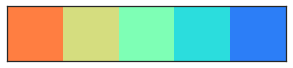

In [23]:
cols = select

c = sns.color_palette("rainbow_r", len(select)+2).as_hex()
color = c
sns.palplot(c)

In [24]:
df1

,Org1,RPAgg1,RPAgg5
Guassian noise stddev,,,
0.0,0.9953,0.9918,0.9914
0.12,0.9944,0.9907,0.9906
0.24,0.9755,0.9641,0.9788
0.36,0.7692,0.7506,0.9003
0.48,0.4558,0.4742,0.6791
0.6,0.2500,0.2708,0.4197
0.72,0.1537,0.1809,0.2658


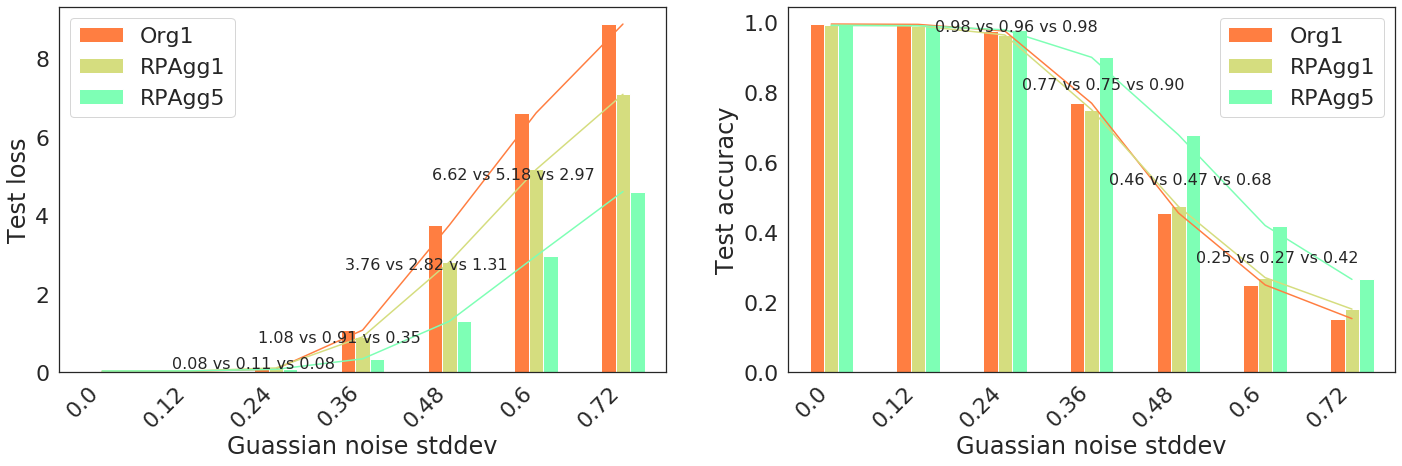

In [29]:
sns.set(style= 'white',font_scale = 2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7), sharex=False, sharey=False, )
ax2, ax1 = axes        

df1[cols].plot(kind = 'line',  color = color, ax = ax1, legend = False)
df1[cols].plot(kind = 'bar',  color = color, ax = ax1)
for x,y in enumerate(df1.index):

    v = ' vs '.join(["%.2f" % i for i in df1.iloc[x].tolist()])
    if (x >= 2) & (x < 6):
        ax1.annotate(v, xy = (x-0.8, df1.iloc[x].mean() +0.001), fontsize= 16)
    
    
ax1.set_ylabel('Test accuracy')
ax1.set_xticklabels(labels = df1.index,rotation=45, ha = 'right')

df2[cols].plot(kind = 'line',  color = color, ax = ax2, legend = False)
df2[cols].plot(kind = 'bar', color = color, ax = ax2)


for x,y in enumerate(df2.index):
    v = ' vs '.join(["%.2f" % i for i in df2.iloc[x].tolist()])
    if (x >= 2) & (x < 6):
        ax2.annotate(v, xy = (x-1.2, df2.iloc[x].mean()), fontsize= 16)
    
    
# for x,y in enumerate(df2.values):
#     ax2.annotate('%.3f' % y, xy = (x-0.25, y+0.002))
ax2.set_ylabel('Test loss')
ax2.set_xticklabels(labels = df2.index,rotation=45, ha = 'right')

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
plt.savefig(os.path.join(results_save_folder, 'performance_Guassian_Noise_test.png'), bbox_inches='tight', dpi=400)